# Transport through a barrier

All systems so far had a flat potential.  In this notebook, we will change this.

Basic setup (like in the previous notebook):

In [1]:
import numpy as np
import kwant
%run matplotlib_setup.ipy
from matplotlib import pyplot

/anaconda3/lib/python3.6/site-packages/kwant-1.4.0a0.dev27+g5844d3c-py3.6-macosx-10.7-x86_64.egg/kwant/solvers/default.py:18: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  "Performance can be very poor in this case.", RuntimeWarning)


In [2]:
lat = kwant.lattice.square()

## "MOSFET" toy model

Let's construct a system like the wire of the previous notebook, except that the scattering region will have a higher (but still flat) potential.

The leads are unchanged, so we take the following function directly from the previous notebook.

In [3]:
def make_lead_x(W=10, t=1):
    syst = kwant.Builder(kwant.TranslationalSymmetry([-1, 0]))
    syst[(lat(0, y) for y in range(W))] = 4 * t
    syst[lat.neighbors()] = -t
    return syst

The next one is slightly modified: the onsite value is now no longer a constant but a *value function*.

Kwant’s value functions are used when there are parameters to the Hamiltonian.  Kwant will call them only when a calculation is requested, at the last possible moment.  The onsite function always take one arguments (the site), and an arbitrary number of parameters that are supplied by the user.  Here, there is only one such parameter: `V`.

In [4]:
def make_wire_with_flat_potential(W=10, L=2, t=1):
    def onsite(s, V):
        return (4 - V) * t

    # Construct the scattering region.
    sr = kwant.Builder()
    sr[(lat(x, y) for x in range(L) for y in range(W))] = onsite
    sr[lat.neighbors()] = -t

    # Build and attach lead from both sides.
    lead = make_lead_x(W, t)
    sr.attach_lead(lead)
    sr.attach_lead(lead.reversed())

    return sr

The following function also needs to be modified slightly: instead of plotting transmission as a function of energy, it plots transmission as the function of the Hamiltonian parameter, for a fixed energy.

Observe how `args=[param]` is used to pass the user-specified Hamiltonian parameters to `kwant.smatrix`.  `args` must be a sequence of parameters, even if it's only a single one in this case.

In [5]:
def plot_transmission(syst, energy, params):
    # Compute conductance
    trans = []
    for param in params:
        smatrix = kwant.smatrix(syst, energy, args=[param])
        trans.append(smatrix.transmission(1, 0))
    pyplot.plot(params, trans)

Let's put the above functions to some use:

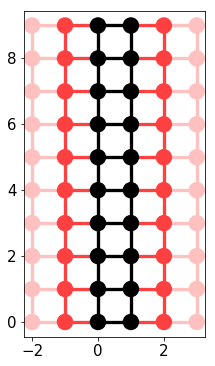

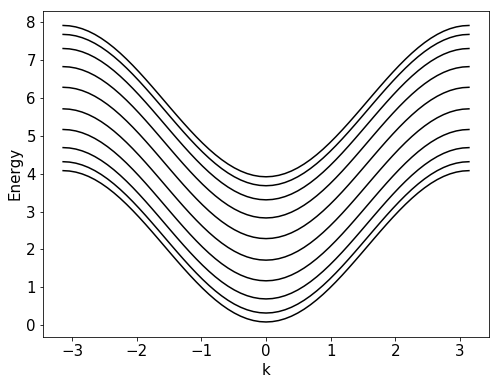

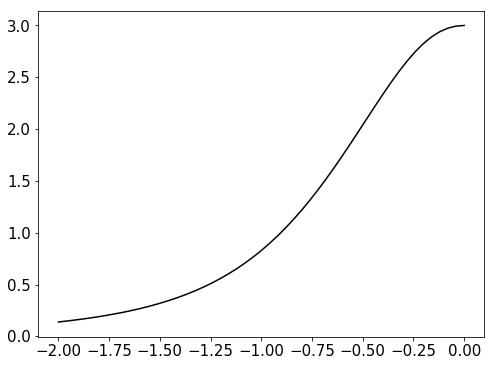

In [6]:
_syst = make_wire_with_flat_potential()
kwant.plot(_syst)
_syst = _syst.finalized()
kwant.plotter.bands(_syst.leads[0])
plot_transmission(_syst, 1, np.linspace(-2, 0, 51))

#### Your turn!
Play with the parameters (width of the barrier, voltage range, etc.) and see how this affects the results.

## Quantum point contact

What will happen if we open a hole in the potential barrier?  This time we will try to use a more realistic potential.

The following cell defines the potential that we are going to use.

In [7]:
from math import atan2, pi, sqrt

def rectangular_gate_pot(distance, left, right, bottom, top):
    """Compute the potential of a rectangular gate.
    
    The gate hovers at the given distance over the plane where the
    potential is evaluated.
    
    Based on J. Appl. Phys. 77, 4504 (1995)
    http://dx.doi.org/10.1063/1.359446
    """
    d, l, r, b, t = distance, left, right, bottom, top

    def g(u, v):
        return atan2(u * v, d * sqrt(u**2 + v**2 + d**2)) / (2 * pi)

    def func(x, y, voltage):
        return voltage * (g(x-l, y-b) + g(x-l, t-y) +
                          g(r-x, y-b) + g(r-x, t-y))

    return func

_gate1 = rectangular_gate_pot(10, 20, 50, -50, 15)
_gate2 = rectangular_gate_pot(10, 20, 50, 25, 90)
def qpc_potential(site, V):
    x, y = site.pos
    return _gate1(x, y, V) + _gate2(x, y, V)

The function below is almost like `make_wire_with_flat_potential`.  The difference is that it can be tuned to use a general potential using its first parameter.

In [8]:
def make_barrier(pot, W=40, L=70, t=1):
    def onsite(*args):
        return 4 * t - pot(*args)

    # Construct the scattering region.
    sr = kwant.Builder()
    sr[(lat(x, y) for x in range(L) for y in range(W))] = onsite
    sr[lat.neighbors()] = -t

    # Build and attach lead from both sides.
    lead = make_lead_x(W, t)
    sr.attach_lead(lead)
    sr.attach_lead(lead.reversed())

    return sr

Let's construct the system and plot the potential.  The lambda expression is used to fix the gate voltage to a particular value.

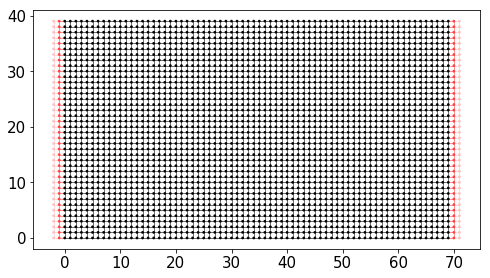

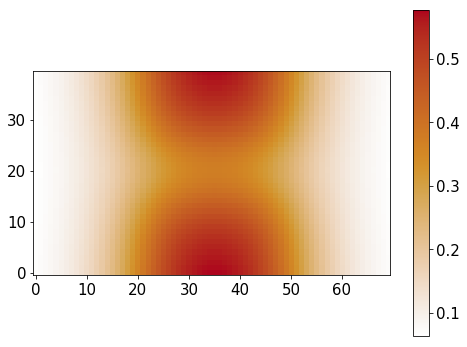

In [9]:
qpc = make_barrier(qpc_potential)
kwant.plot(qpc);
kwant.plotter.map(qpc, lambda s: qpc_potential(s, 1));

To get an idea of the involved energy scales it's useful to plot the band structure:

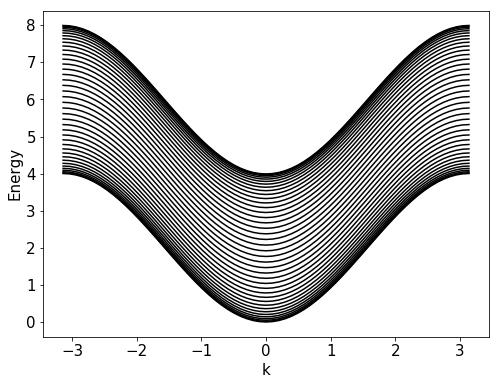

In [10]:
fqpc = qpc.finalized()
kwant.plotter.bands(fqpc.leads[0]);

Finally, let's plot transmission as a function of the gate voltage.  We see the hallmark of the QPC: conductance quantization.  It's similar to what we saw in the clean wire, but now much more "realistic".

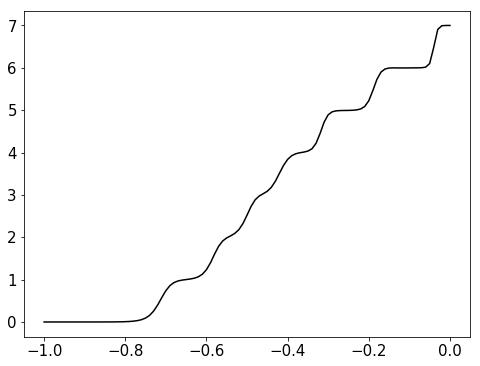

In [11]:
plot_transmission(fqpc, 0.3, np.linspace(-1, 0, 101))

#### Your turn!
Play with the parameters?  For example, what happens if you make the QPC potential "shorter"?